### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [453]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

In [454]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [455]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)

In [456]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [457]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [458]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [301]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train.parquet", replace_negative_one=False)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test.parquet", replace_negative_one=False)

Shape of data: (5531451, 190)
Shape of data: (11363762, 190)
CPU times: user 9.76 s, sys: 15 s, total: 24.8 s
Wall time: 12.1 s


In [302]:
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [303]:
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

### Fix category columns

In [304]:
%%time
train.loc[:, CATEGORY_COLUMNS] = train.loc[:, CATEGORY_COLUMNS].astype("category")
test.loc[:, CATEGORY_COLUMNS] = test.loc[:, CATEGORY_COLUMNS].astype("category")

CPU times: user 1.08 s, sys: 1.22 s, total: 2.29 s
Wall time: 2.31 s


In [305]:
for col in CATEGORY_COLUMNS:
    if train[col].dtype != test[col].dtype:
        print(col)

### D_64

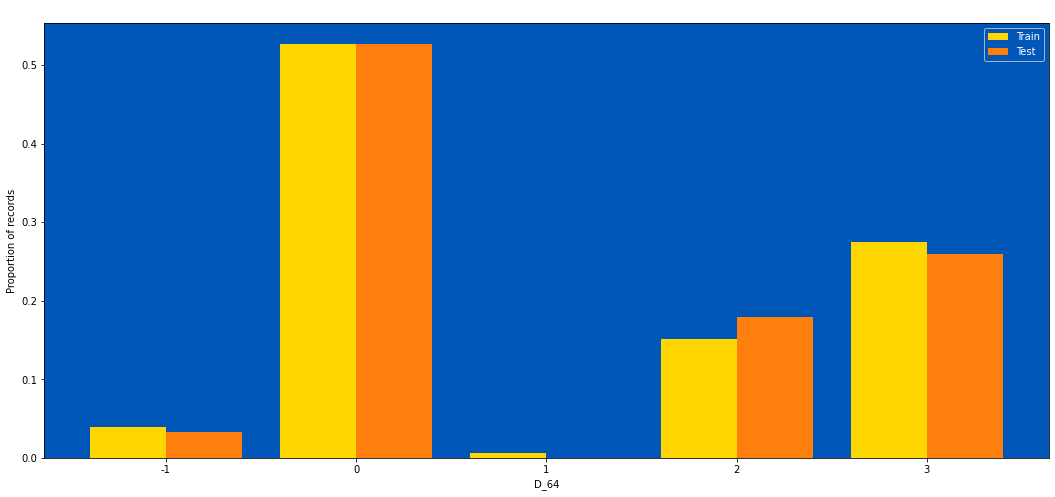

In [313]:
plot_train_test_distribution(train, test, col="D_64")

- D_64 has one additional category (1) in training set which is not in test set

0 null count, 0.000 null proportion
nan of the targets have label = 1


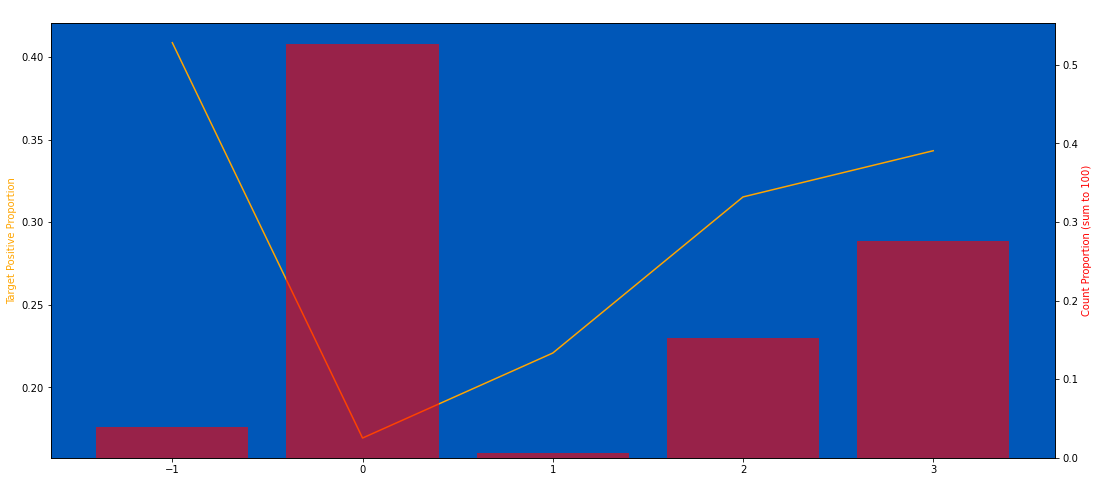

In [314]:
single_col_target_check(train, "D_64")

- Category 1 has different target distribution with other categories, can't merge and remove category 1
- The higher the D_64, the higher the average default rate;
- Records with missing D_64 has the highest chance of being default (about 40%), set category -1 (NaN) as category 4

In [315]:
%%time
train["D_64"] = train["D_64"].replace(-1, 4).astype(np.int8)
test["D_64"] = test["D_64"].replace(-1, 4).astype(np.int8)

CPU times: user 72.8 ms, sys: 185 ms, total: 258 ms
Wall time: 262 ms


0 null count, 0.000 null proportion
nan of the targets have label = 1


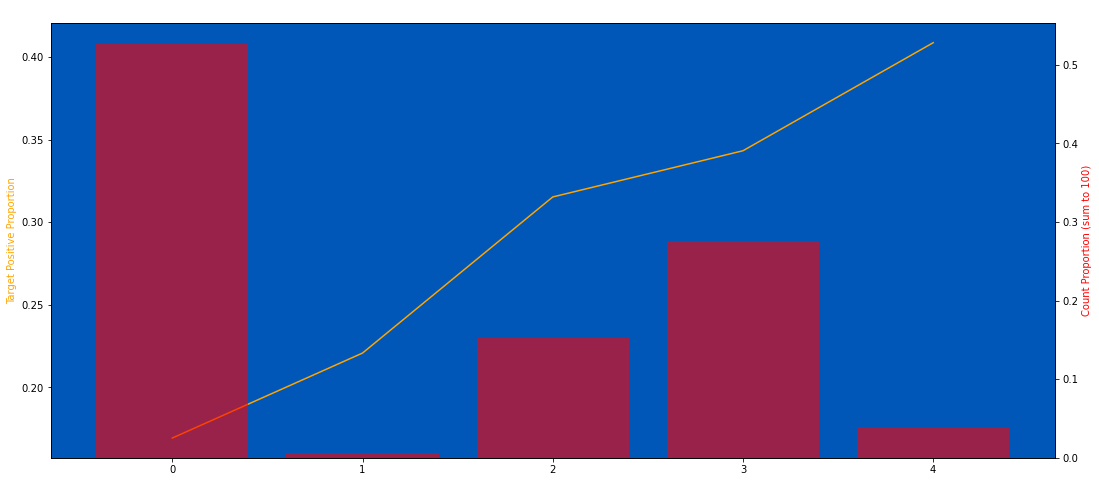

In [316]:
single_col_target_check(train, "D_64")

### D_68

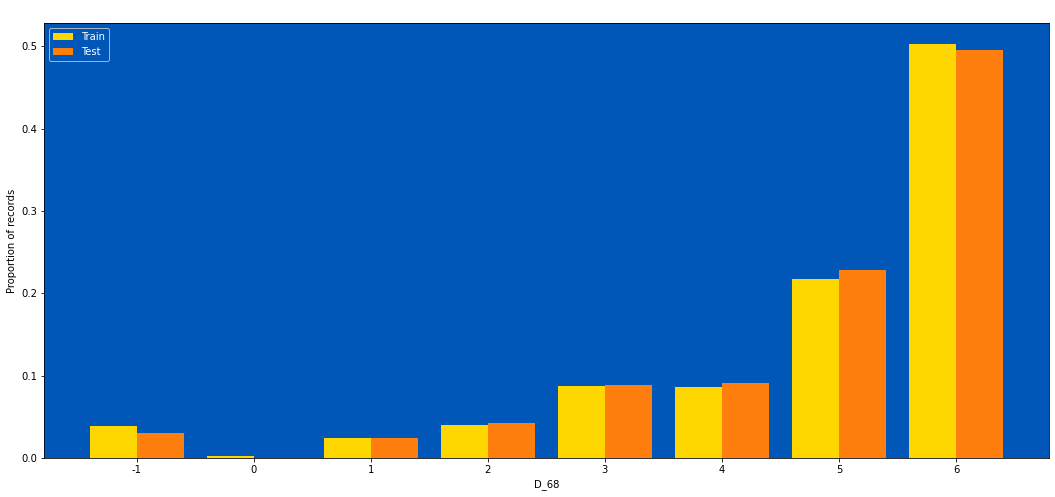

In [317]:
plot_train_test_distribution(train, test, col="D_68")

- D_68 has one additional category (0) in training set which is not in test set

0 null count, 0.000 null proportion
nan of the targets have label = 1


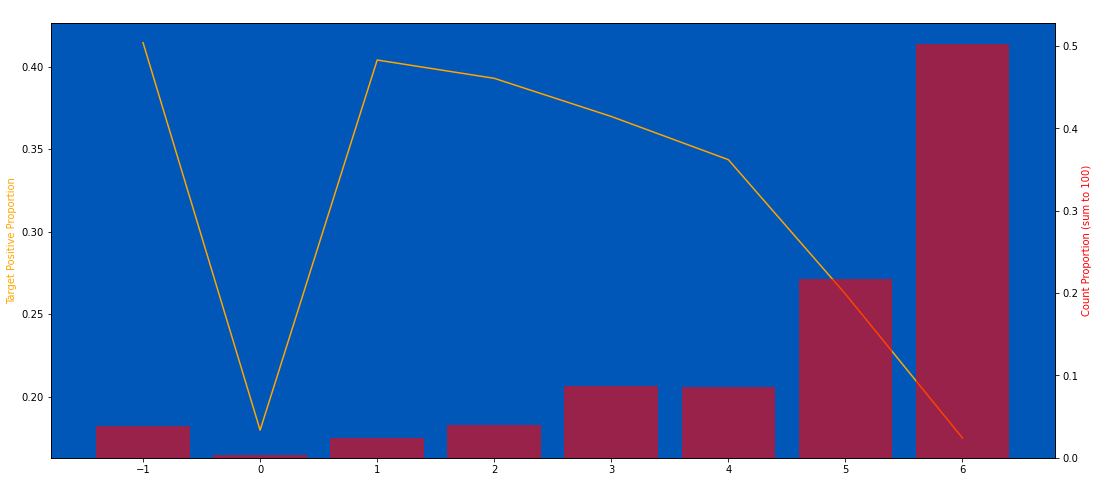

In [318]:
single_col_target_check(train, "D_68")

- Category 0 has similar target distribution as category 6, merge it into category 6
- Then, set category -1 (NaN) into 0 since the distribution is similar

In [319]:
%%time
train["D_68"] = train["D_68"].replace(0, 6).replace(-1, 0).astype(np.int8)
test["D_68"] = test["D_68"].replace(0, 6).replace(-1, 0).astype(np.int8)

CPU times: user 86 ms, sys: 214 ms, total: 300 ms
Wall time: 300 ms


0 null count, 0.000 null proportion
nan of the targets have label = 1


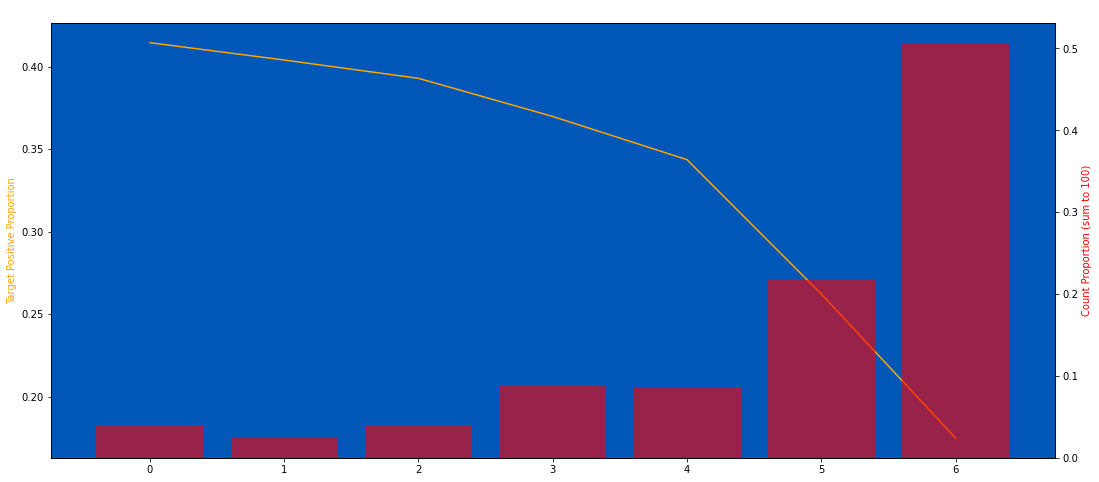

In [320]:
single_col_target_check(train, "D_68")

In [321]:
check_overlap_missing(train, "D_64", "D_68")

D_64 missing count 0
D_68 missing count 0
Both D_64 & D_68 missing count 0


### B_8

In [352]:
%%time
train["B_8"] = train["B_8"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["B_8"] = test["B_8"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.38 s, sys: 1.9 s, total: 5.28 s
Wall time: 6.66 s


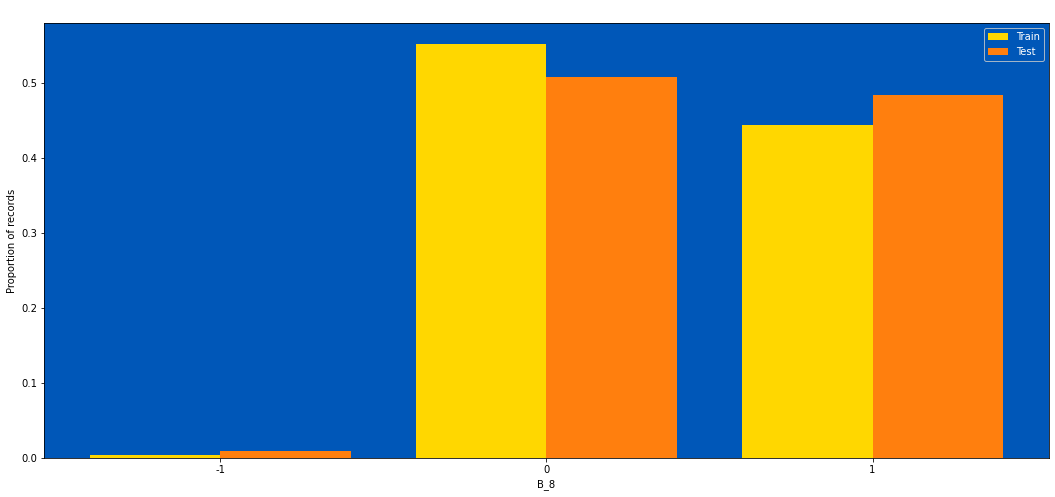

In [353]:
plot_train_test_distribution(train, test, col="B_8")

0 null count, 0.000 null proportion
nan of the targets have label = 1


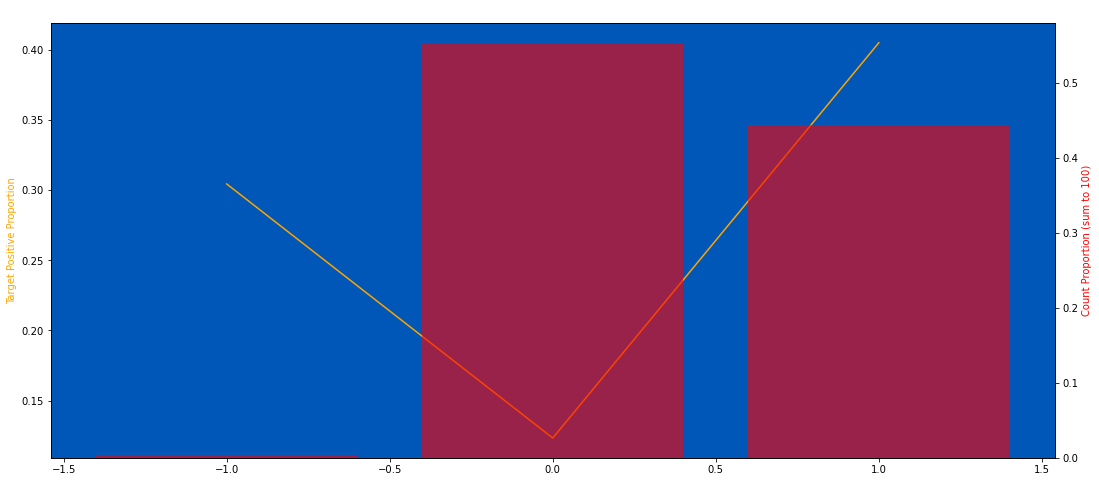

In [354]:
single_col_target_check(train, "B_8")

### B_36

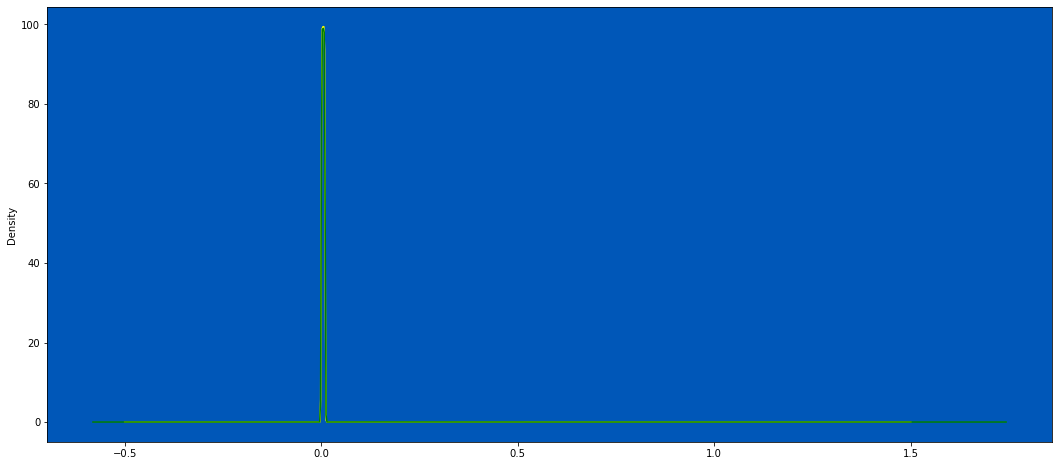

In [378]:
plot_train_test_distribution(train, test, col="B_36")

In [379]:
%%time
train["B_36"] = train["B_36"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)
test["B_36"] = test["B_36"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)

CPU times: user 2.73 s, sys: 1.93 s, total: 4.66 s
Wall time: 5.87 s


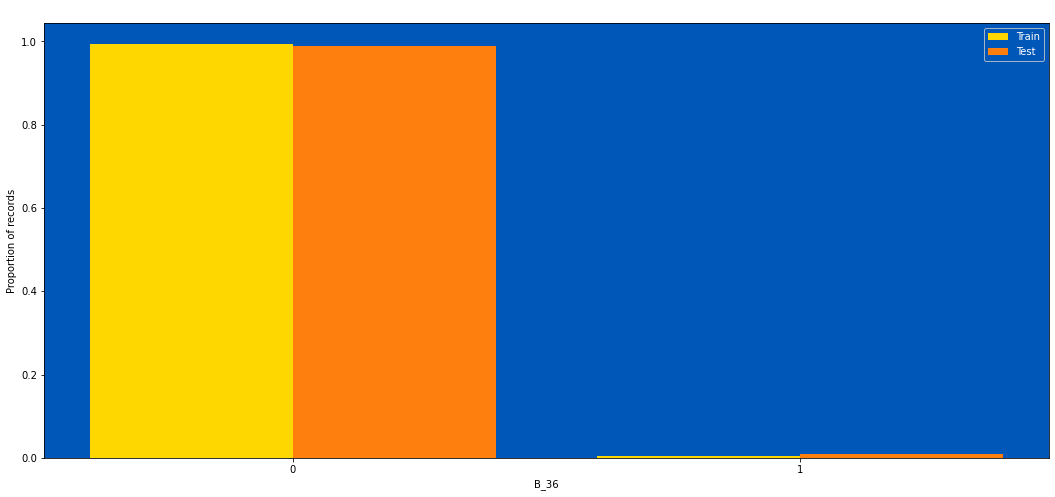

In [381]:
plot_train_test_distribution(train, test, col="B_36")

0 null count, 0.000 null proportion
nan of the targets have label = 1


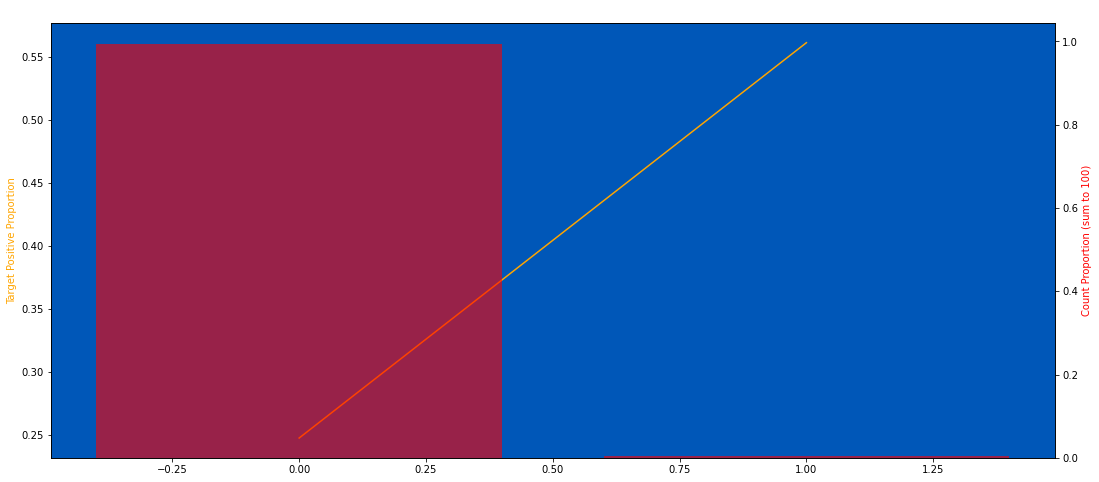

In [382]:
single_col_target_check(train, "B_36")

### D_54

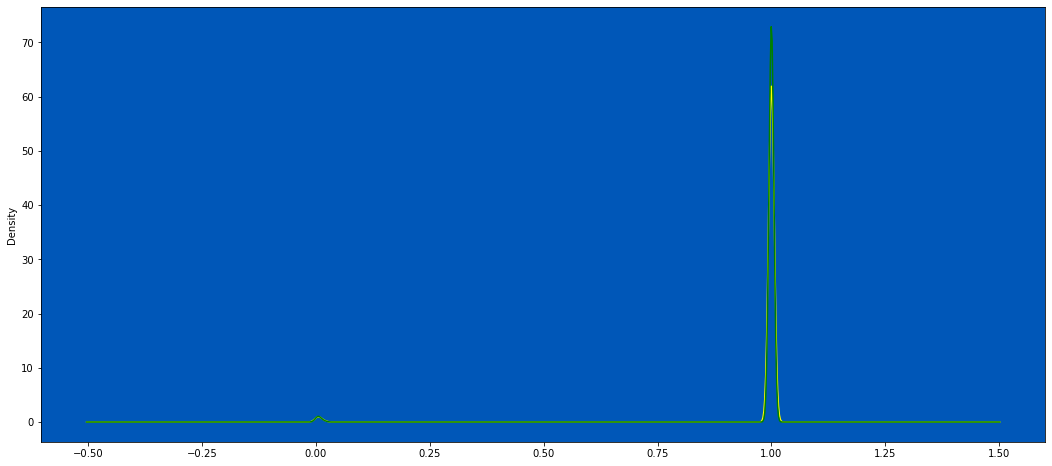

In [383]:
plot_train_test_distribution(train, test, col="D_54")

In [384]:
%%time
train["D_54"] = train["D_54"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_54"] = test["D_54"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.4 s, sys: 1.61 s, total: 5.01 s
Wall time: 6.43 s


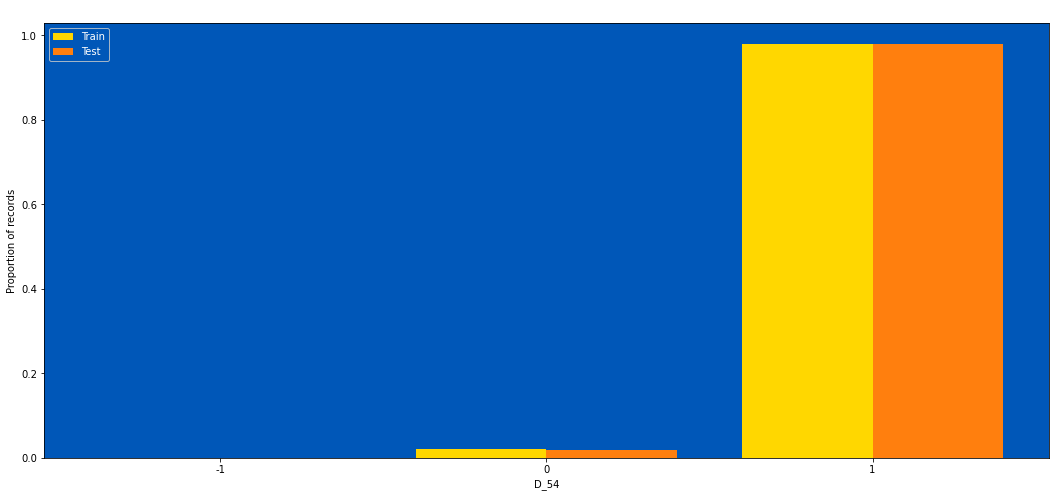

In [385]:
plot_train_test_distribution(train, test, col="D_54")

0 null count, 0.000 null proportion
nan of the targets have label = 1


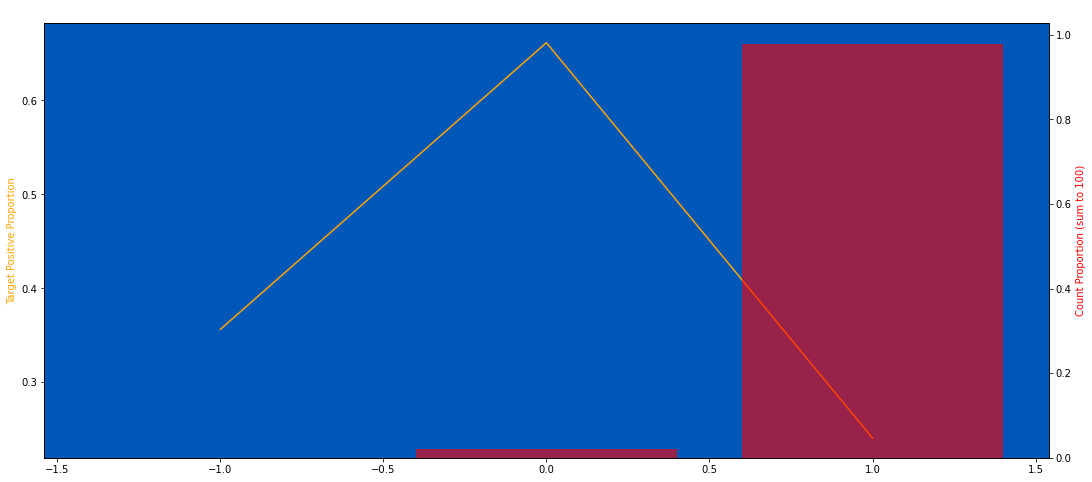

In [386]:
single_col_target_check(train, "D_54")

In [401]:
check_overlap_missing(train, "D_54", "D_59", n1=-1, n2=-1)

D_54 missing count 2016
D_59 missing count 106725
Both D_54 & D_59 missing count 2016


In [402]:
train[["D_54", "D_59"]].corr()

,D_54,D_59
D_54,1.000,-0.034
D_59,-0.034,1.000


### D_128

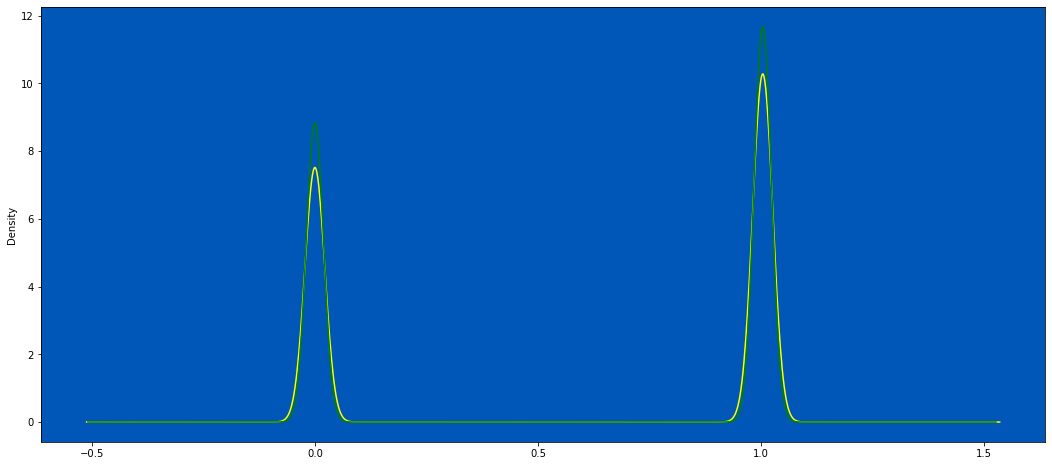

In [403]:
plot_train_test_distribution(train, test, col="D_128")

In [404]:
%%time
train["D_128"] = train["D_128"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_128"] = test["D_128"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.38 s, sys: 2.08 s, total: 5.46 s
Wall time: 7.18 s


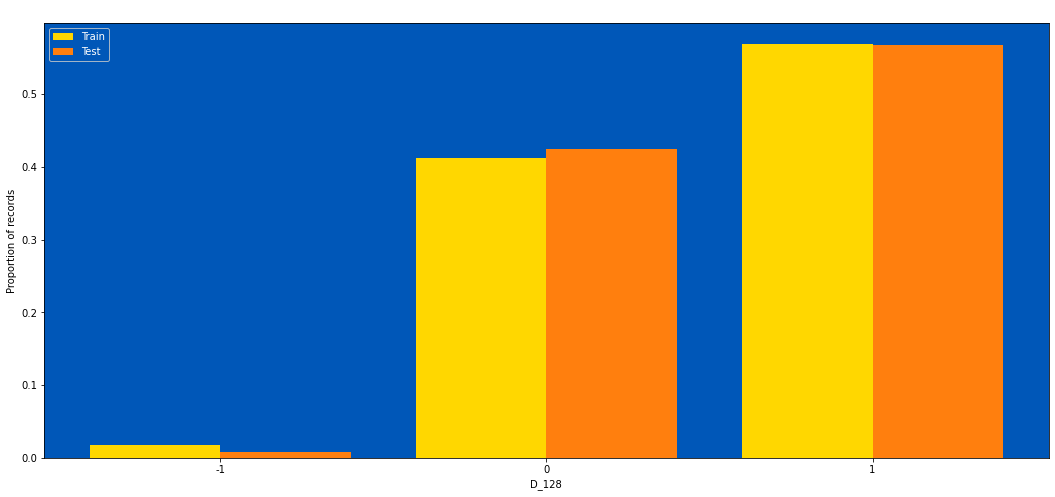

In [405]:
plot_train_test_distribution(train, test, col="D_128")

0 null count, 0.000 null proportion
nan of the targets have label = 1


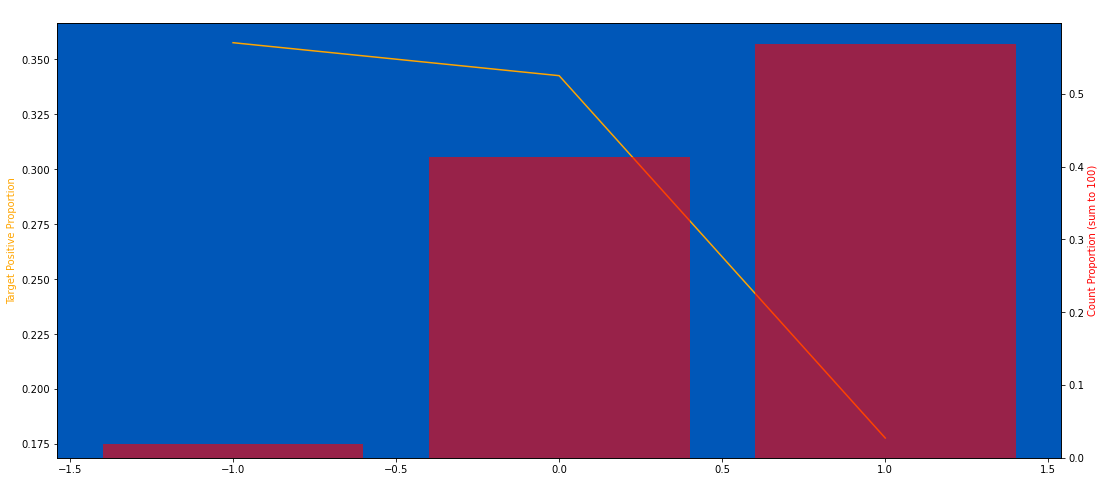

In [406]:
single_col_target_check(train, "D_128")

### D_130

In [407]:
column = "D_130"

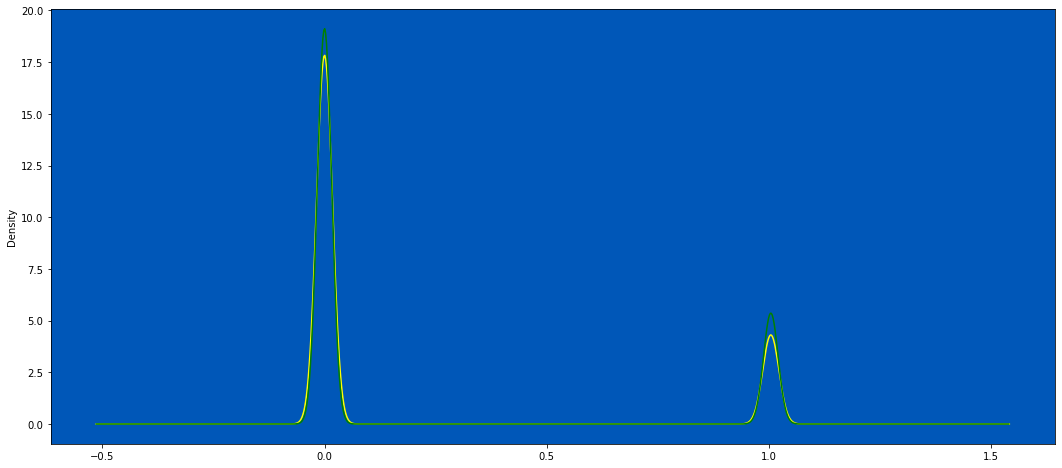

In [408]:
plot_train_test_distribution(train, test, col="D_130")

In [409]:
%%time
train["D_130"] = train["D_130"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_130"] = test["D_130"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.4 s, sys: 2.82 s, total: 6.22 s
Wall time: 11.6 s


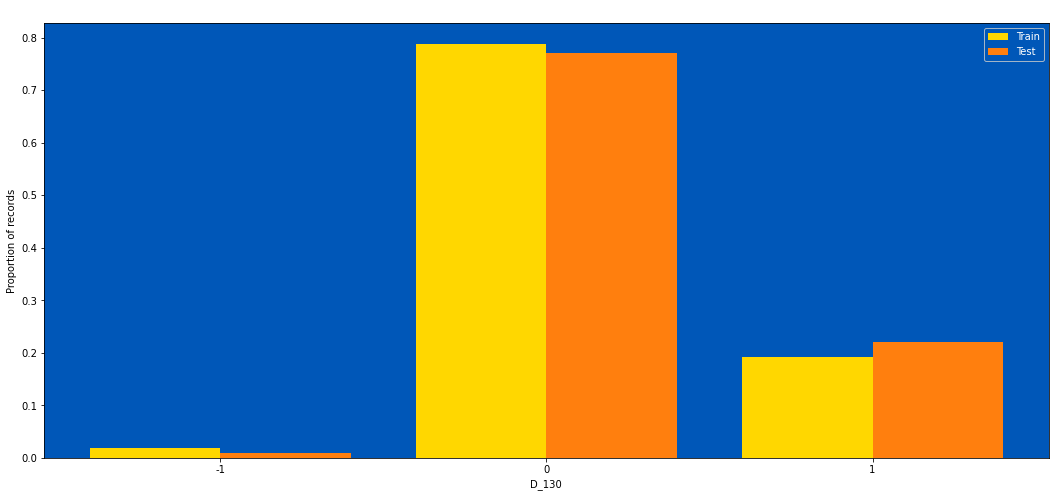

In [410]:
plot_train_test_distribution(train, test, col="D_130")

0 null count, 0.000 null proportion
nan of the targets have label = 1


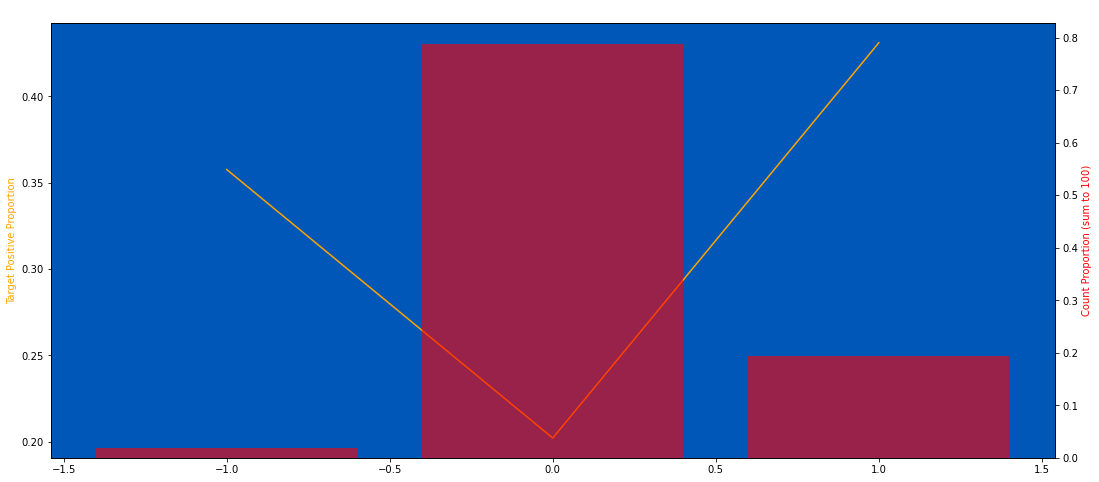

In [411]:
single_col_target_check(train, "D_130")

### R_1

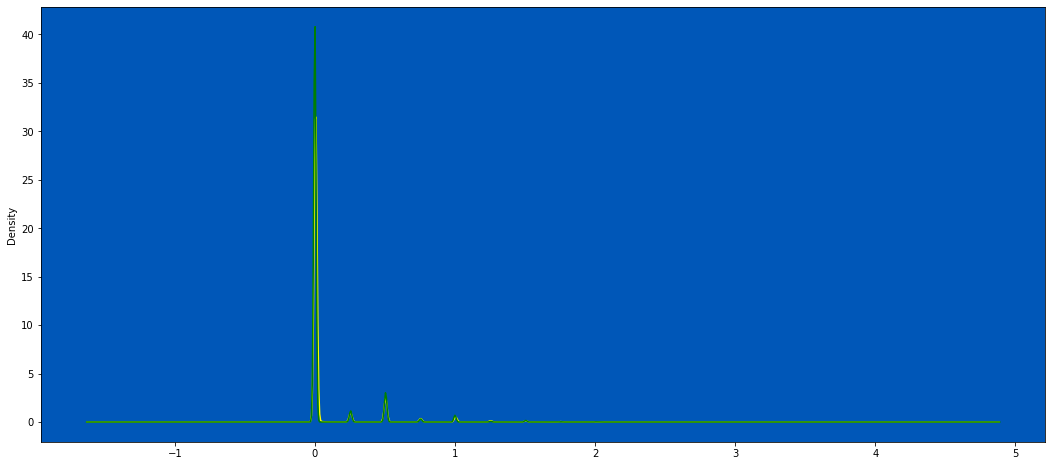

In [417]:
plot_train_test_distribution(train, test, col="R_1")

In [418]:
%%time
train["R_1"] = (train["R_1"] * 4).astype(np.int8)
test["R_1"] = (test["R_1"] * 4).astype(np.int8)

CPU times: user 291 ms, sys: 2.35 s, total: 2.64 s
Wall time: 6.69 s


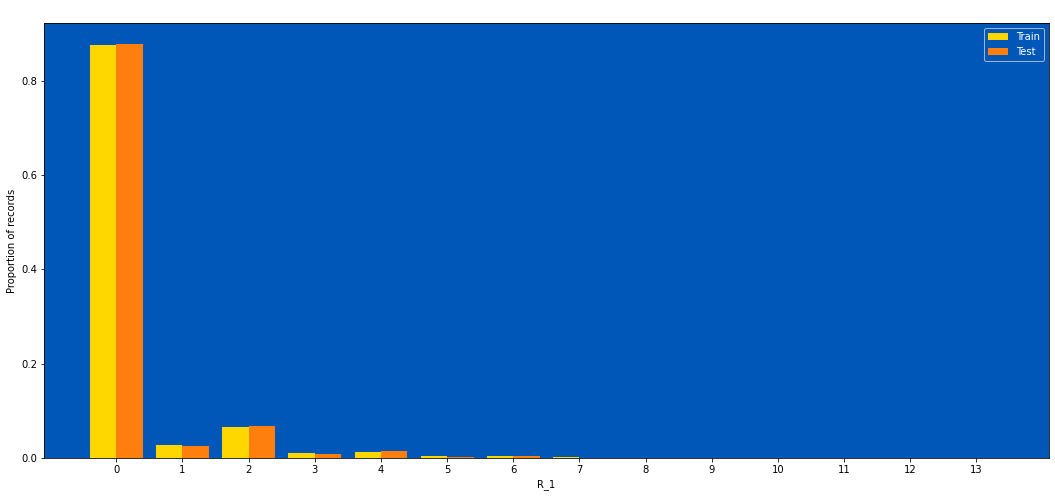

In [419]:
plot_train_test_distribution(train, test, col="R_1")

0 null count, 0.000 null proportion
nan of the targets have label = 1


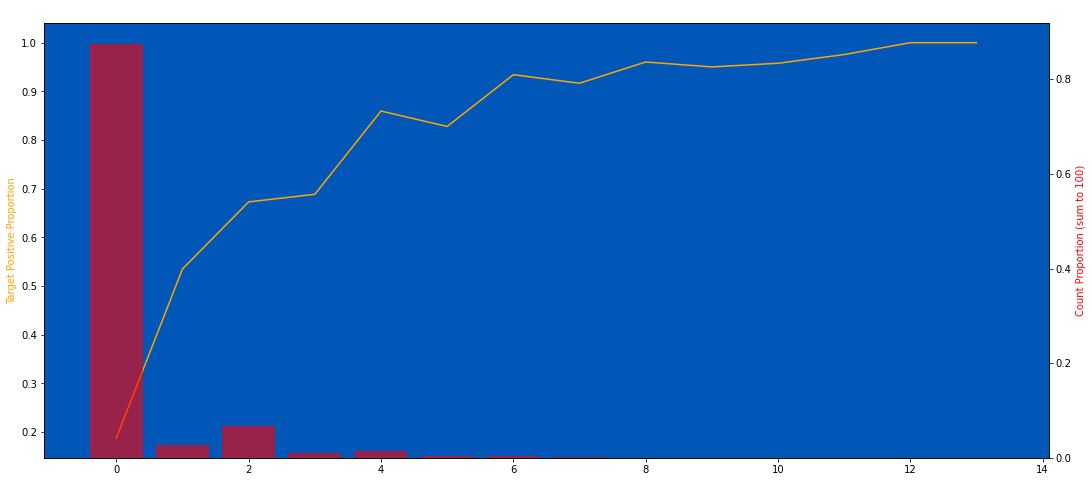

In [420]:
single_col_target_check(train, "R_1")

### S_19

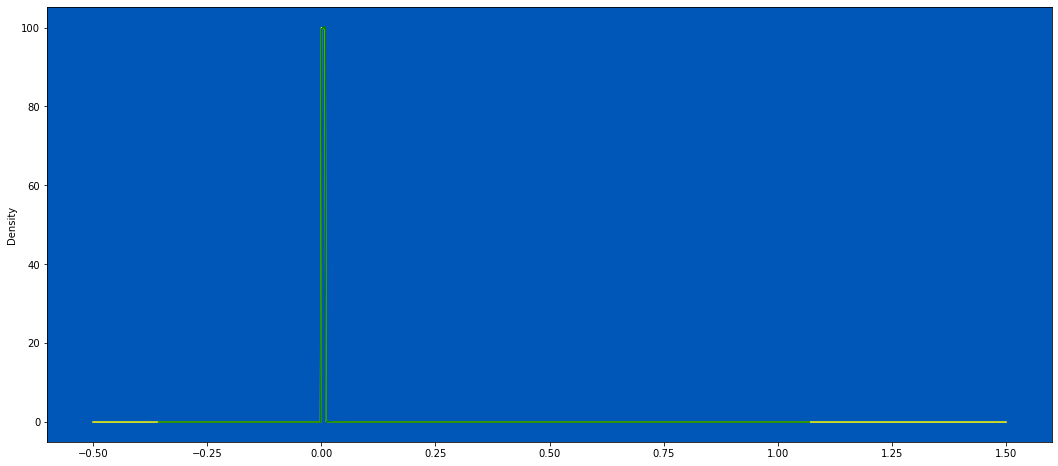

In [421]:
plot_train_test_distribution(train, test, col="S_19")

In [422]:
%%time
train["S_19"] = train["S_19"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)
test["S_19"] = test["S_19"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)

CPU times: user 2.72 s, sys: 2.13 s, total: 4.84 s
Wall time: 6.82 s


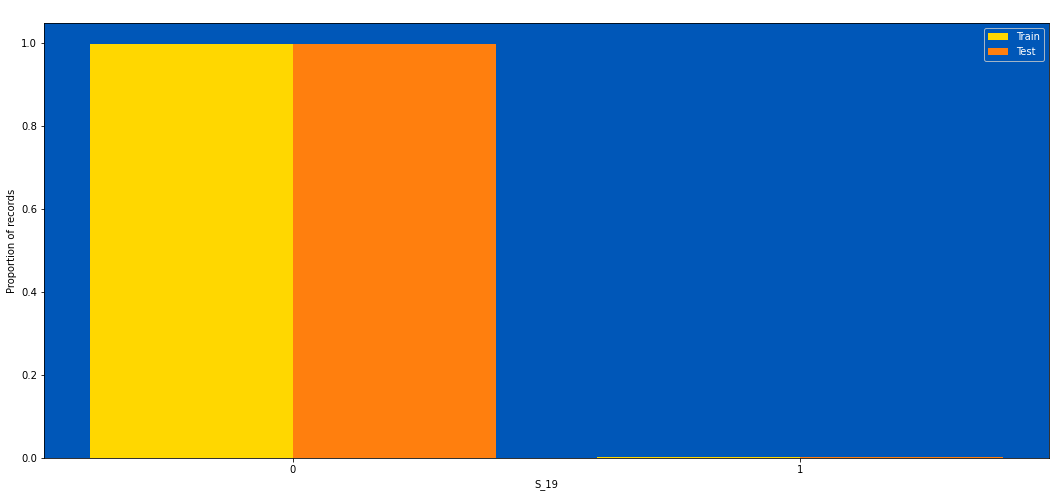

In [423]:
plot_train_test_distribution(train, test, col="S_19")

0 null count, 0.000 null proportion
nan of the targets have label = 1


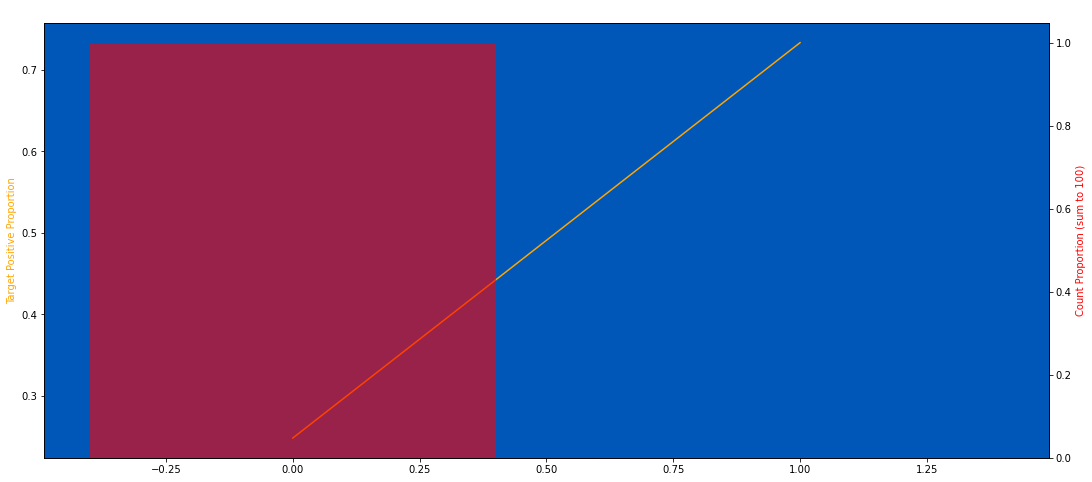

In [424]:
single_col_target_check(train, "S_19")

In [425]:
gc.collect()

73165

### D

In [461]:
number_columns = train.select_dtypes(np.number).columns[2:-2]
b_columns = [col for col in number_columns if col.startswith("B_")]

B_7


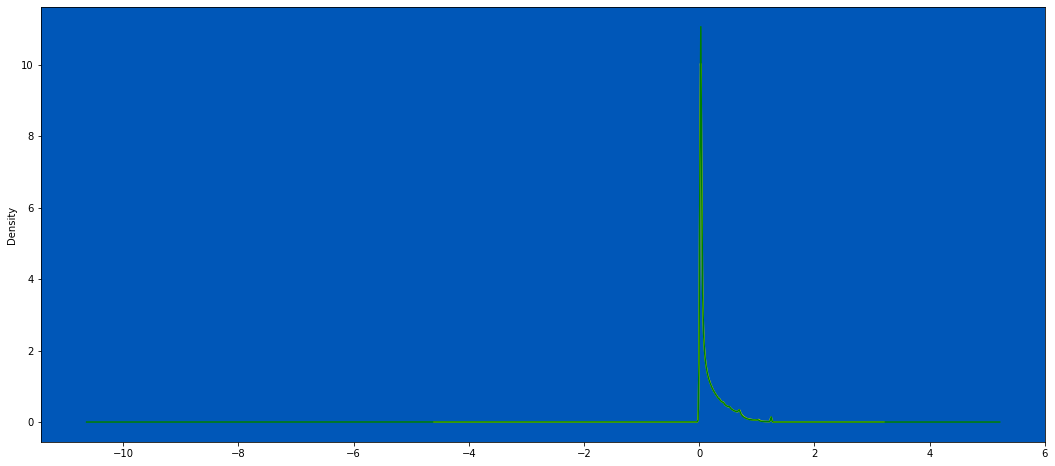

B_8


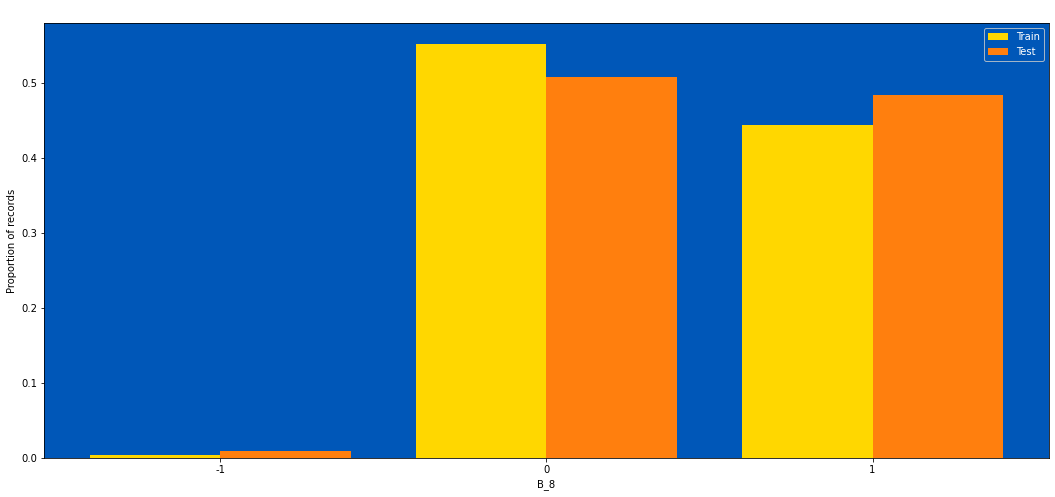

B_9


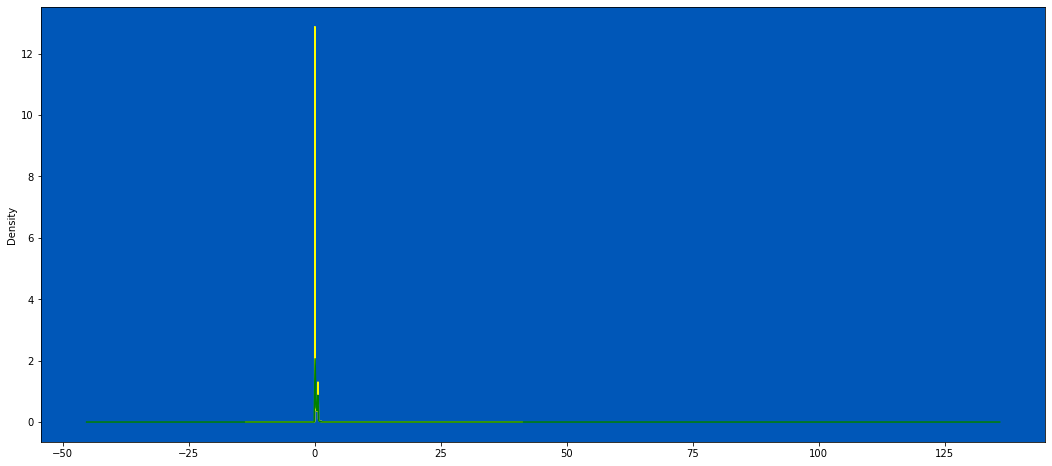

B_10


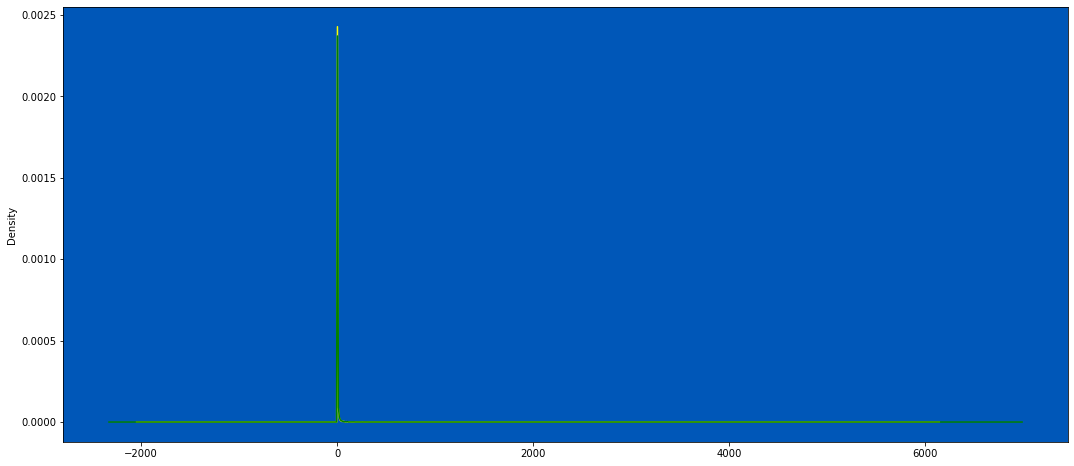

B_11


In [ ]:
%%time
for column in b_columns[6:]:
    print(column)
    plot_train_test_distribution(train, test, col=column)
    gc.collect()

In [442]:
train[column].nunique()

180

In [440]:
train[column].describe()

count   5,531,451.0000
mean            5.0360
std             9.1818
min             0.0000
25%             0.0000
50%             0.0000
75%             8.0000
max           183.0000
Name: D_39, dtype: float64

### Insert row_number

In [426]:
%%time
insert_row_number(train)
insert_row_number(test)

Done insertion
Done insertion
CPU times: user 33.5 s, sys: 622 ms, total: 34.1 s
Wall time: 34.3 s


In [427]:
train.shape, test.shape

((5531451, 194), (11363762, 193))

### Export data out

In [428]:
%%time
train.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/raw_train_data.pkl")
test.to_pickle(f"{RAW_TEST_PICKLE_PATH}/raw_test_data.pkl")

CPU times: user 848 ms, sys: 2.6 s, total: 3.45 s
Wall time: 4.7 s
